In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2021-11-02 10:47:56.285080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-02 10:47:56.285142: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.0 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.3.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# replicate Meshal's pretty plotting colors
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

In [5]:
def repeat(f):
    d = {}
    for p, adata in adatas.items():
        d[p] = f(p, adata)
    return d

In [6]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')

In [13]:
adatas = {
    f'patient_{p}': adata[adata.obs.patient == f'patient_{p}'].copy() for p in ['1', '2', '3', '4']
}

In [7]:
# %%time
# adatas = {
#     f'patient_{p}': sc.read(f'/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_{p}.h5ad') for p in [1, 2, 3, 4]
# }

CPU times: user 45.9 s, sys: 3.16 s, total: 49.1 s
Wall time: 57.4 s


Add `infected` label based on de-multiplexing.

In [20]:
import math
def f(p, adata):
    adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
    adata.obs['infected'] = adata.obs['infected'].astype('category')
    
    # for plotting
    adata.obs['log2(viral_counts)'] = np.log2(adata.obs['viral_counts'].values + 1)
    return adata[~adata.obs.infected.isna()]

adatas = repeat(f)

In [21]:
import anndata as ad
adata = ad.concat(adatas)

## Distributions

Distribution of viral counts in infected vs. uninfected samples, according to demultiplexed labels. This demonstrates that the infection and demultiplexing performed decently as cells labeled as infected have overall more virus than cells labeled as uninfected.

Trying to set attribute `.obs` of view, copying.


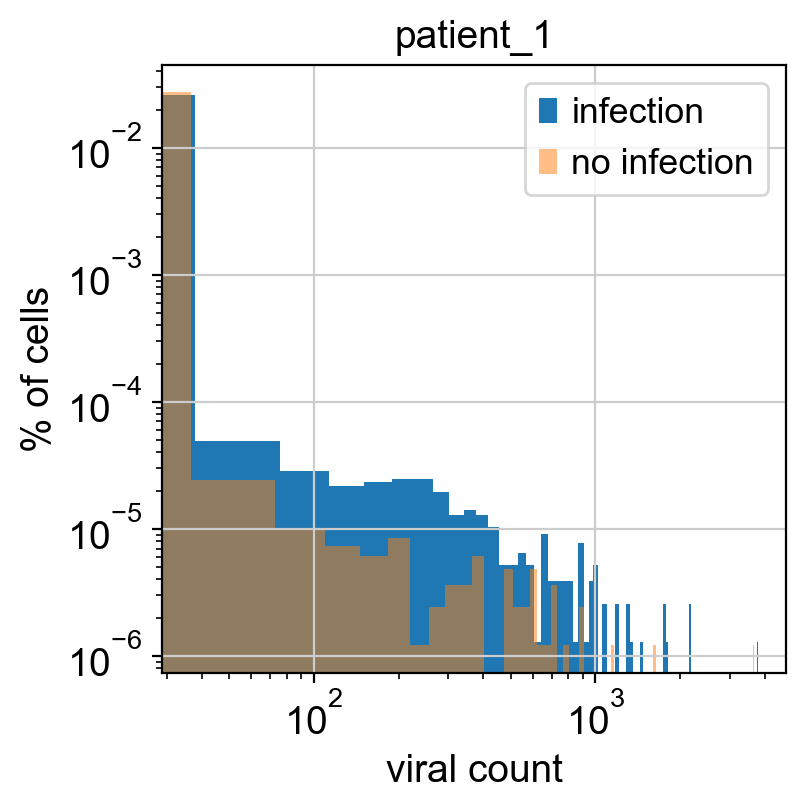

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


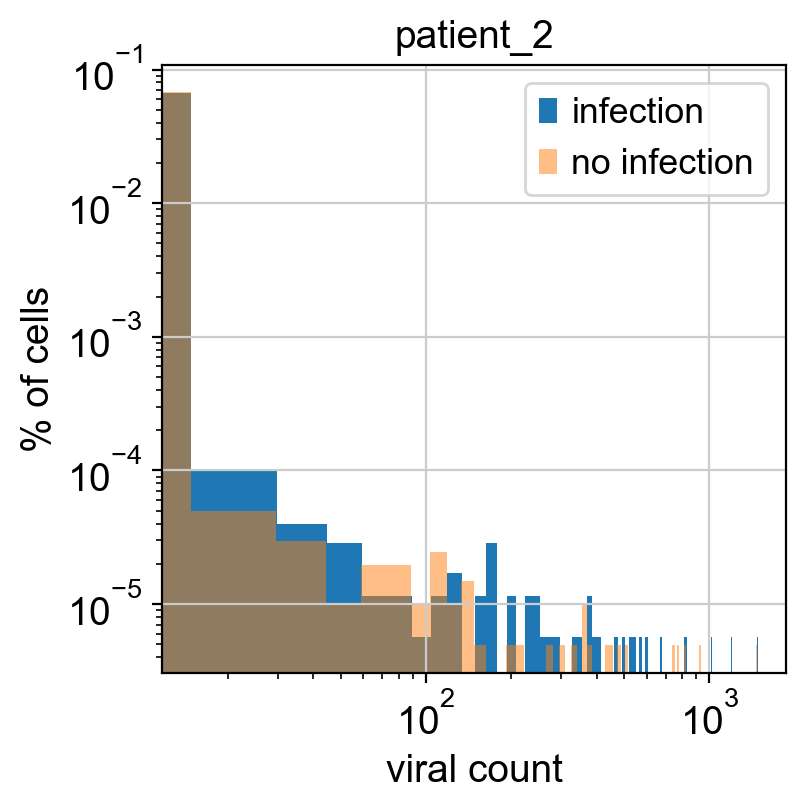

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


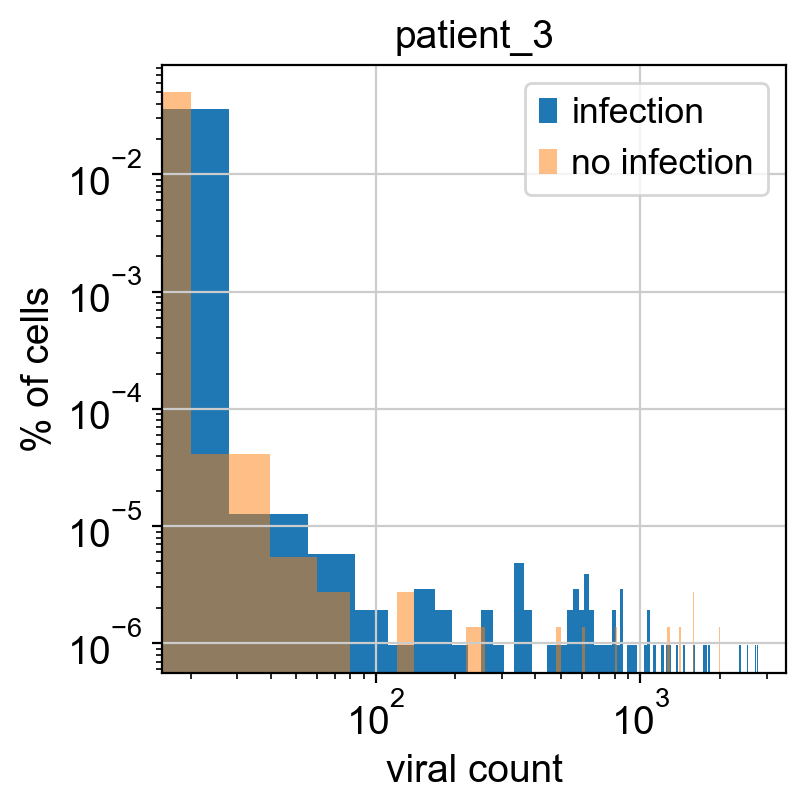

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


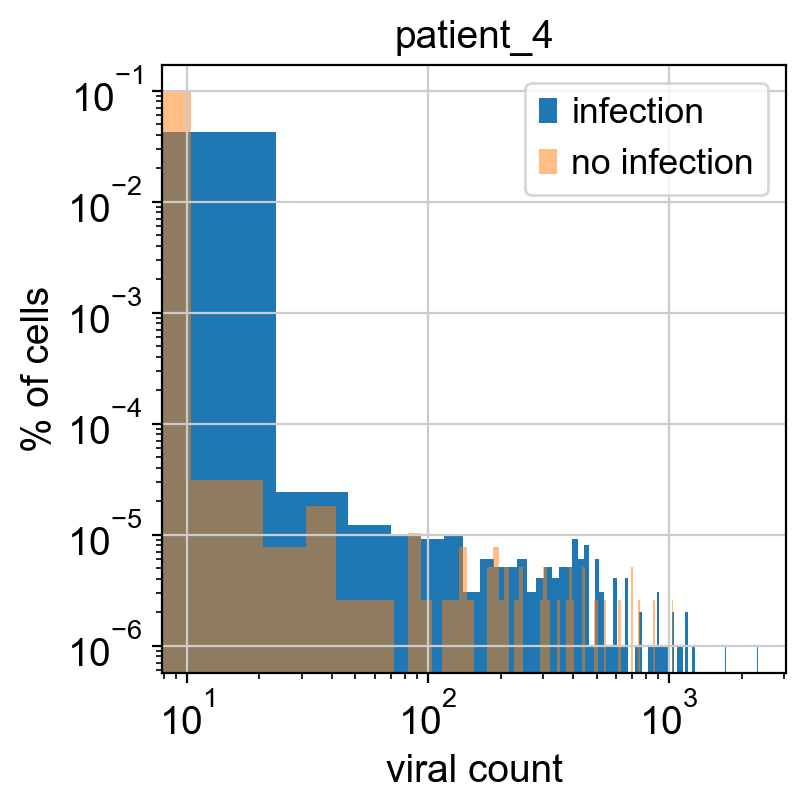

Background level: 2.0


{'patient_1': 427.9519999998447,
 'patient_2': 277.1000000000131,
 'patient_3': 23.305999999996857,
 'patient_4': 105.39999999993597}

In [15]:
def distr_plot(p, adata):
    adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
    inf_values = plt.hist(adata[adata.obs.infected == True].obs.viral_counts.values, bins=100, label='infection', density=True)
    no_inf = adata[adata.obs.infected == False].obs.viral_counts.values
    no_inf_values = plt.hist(no_inf, bins=100, alpha=.5, label='no infection', density=True)
    plt.xlabel('viral count')
    plt.ylabel('% of cells')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(p)
    plt.show()
    
    # Calculate a background level of viral count based on the average in the `no infection` samples.
    thresh = np.quantile(no_inf, .99)
    print('Background level:', thresh)
    
    return thresh
                 
bg_lvl = repeat(distr_plot)                 
bg_lvl_high = repeat(lambda p, adata: np.quantile(adata[adata.obs.infected == False].obs.viral_counts.values, .999))
bg_lvl_high

Text(0, 0.5, 'number of cells')

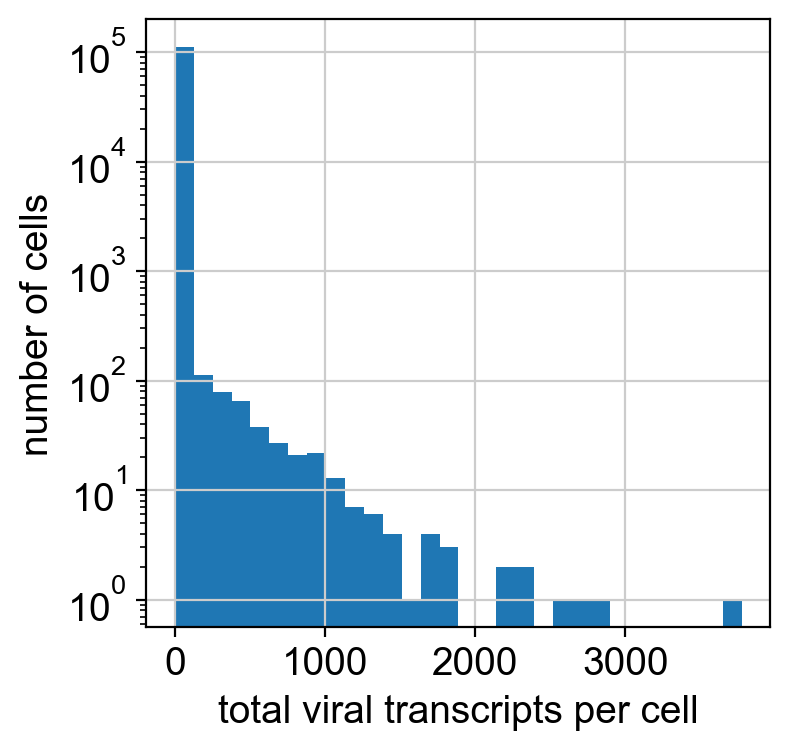

In [22]:
plt.hist(adata[adata.obs.infected == True].obs.viral_counts.values, bins=30)
plt.yscale('log')
plt.xlabel('total viral transcripts per cell')
plt.ylabel('number of cells')
plt.xlim(0, 10000);

Reference from Ravindra et al. (2021), where cells have much higher viral expression overall, but a similar infection rate on day 1 to our data:   
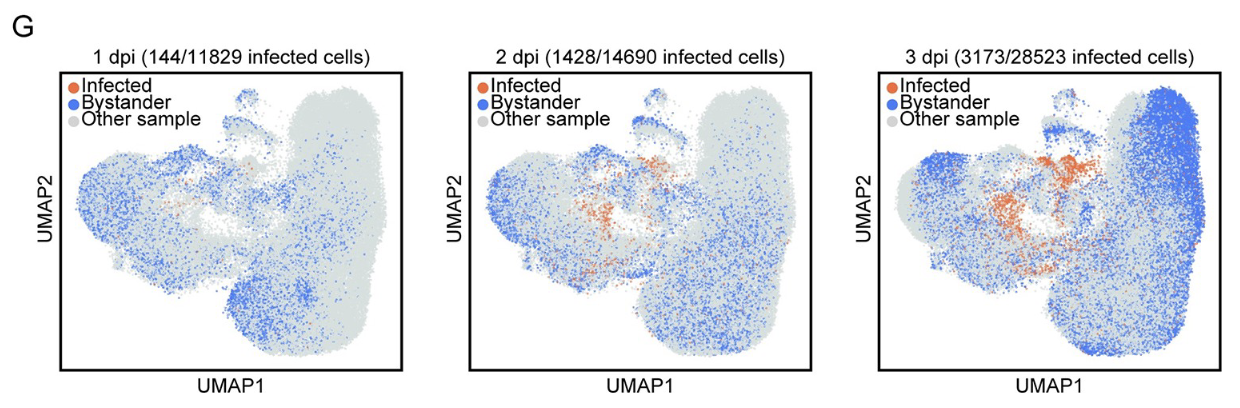
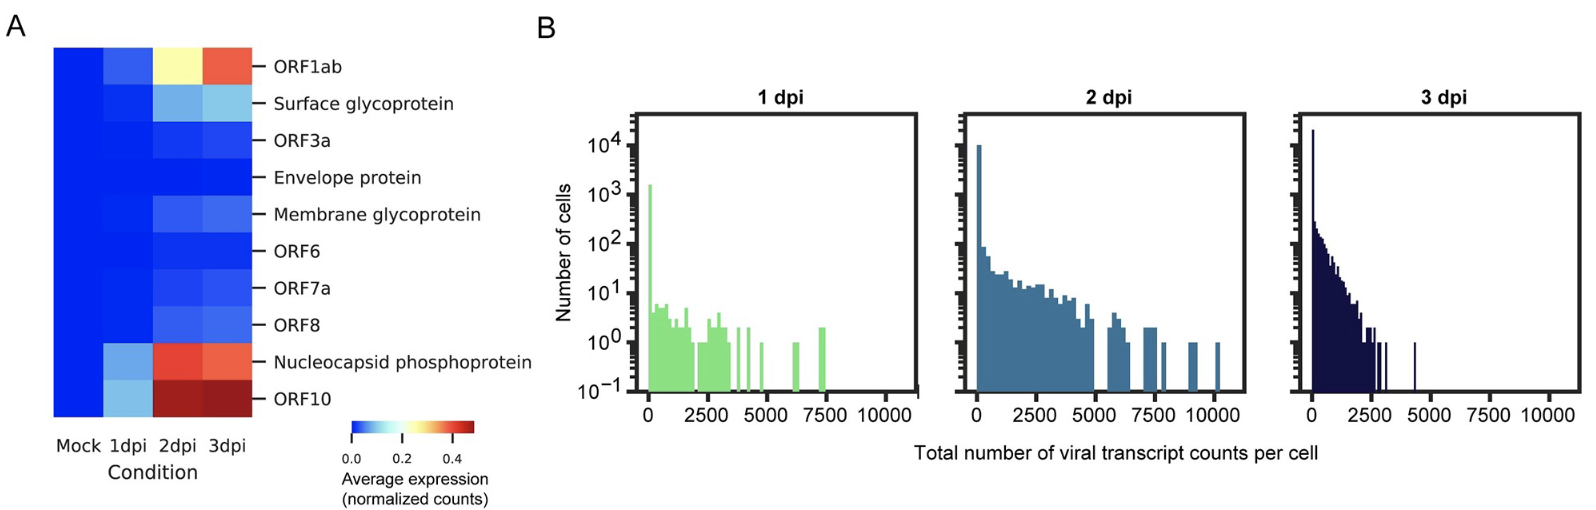

In [62]:
(144*100/118000)

0.12203389830508475

Trying to set attribute `.obs` of view, copying.
... storing 'identifier' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'patient' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'barcode_round' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'treatment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'treatment_virus' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'final_bcs' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'infected_thresh' as categorical


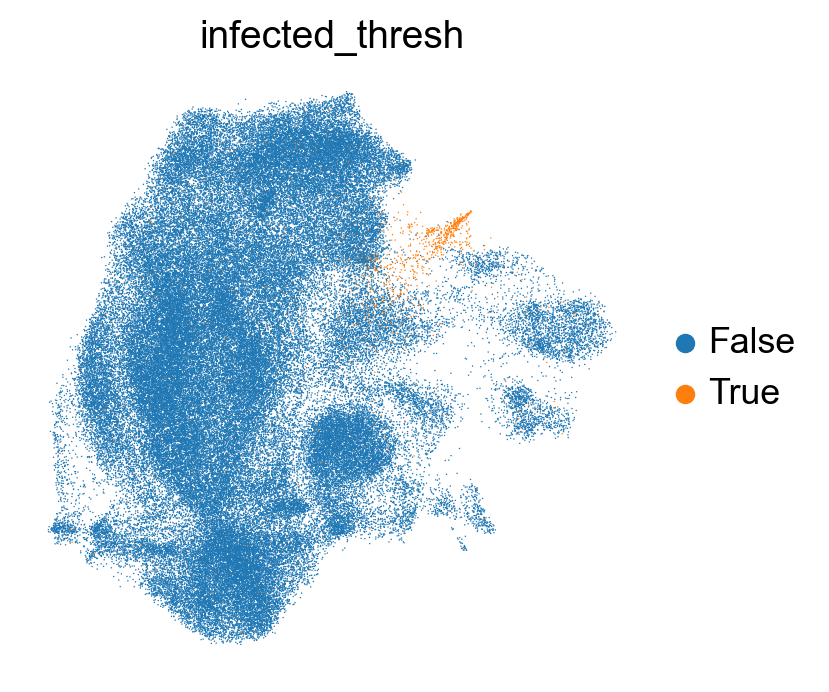

In [41]:
# plot infected
adata.obs['infected_thresh'] = [x > bg_lvl['patient_3'] for x in adata.obs.viral_counts]
adata.obs['infected_thresh'] = adata.obs['infected_thresh'].astype(str)
sc.pl.umap(adata[adata.obs.infected == True], color='infected_thresh')

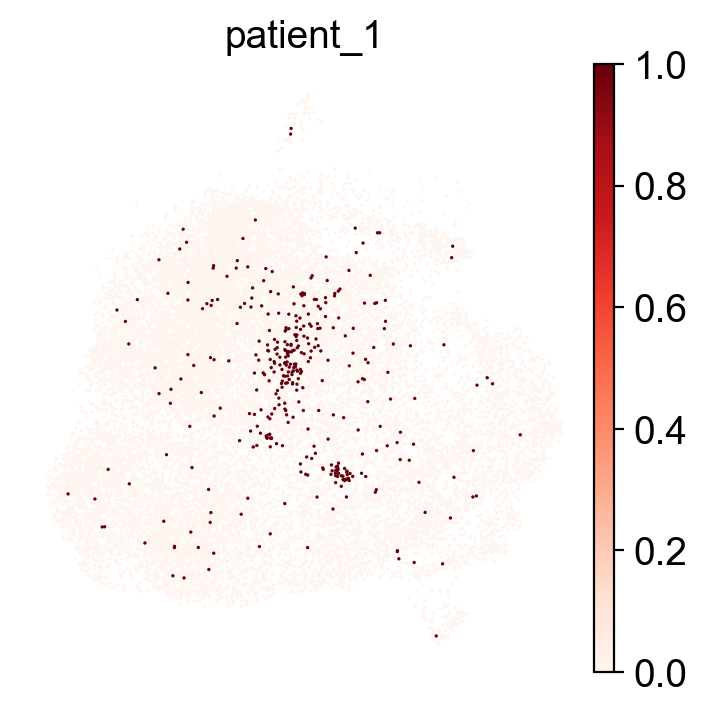

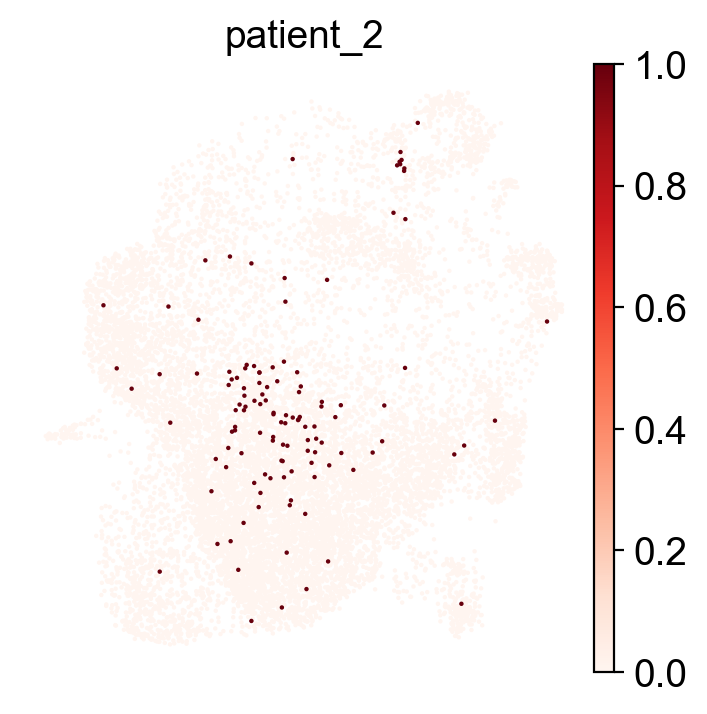

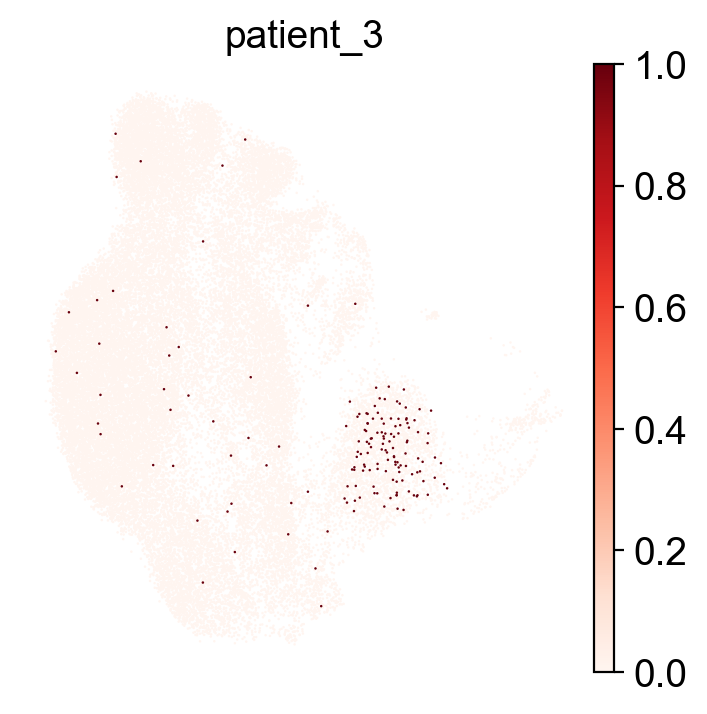

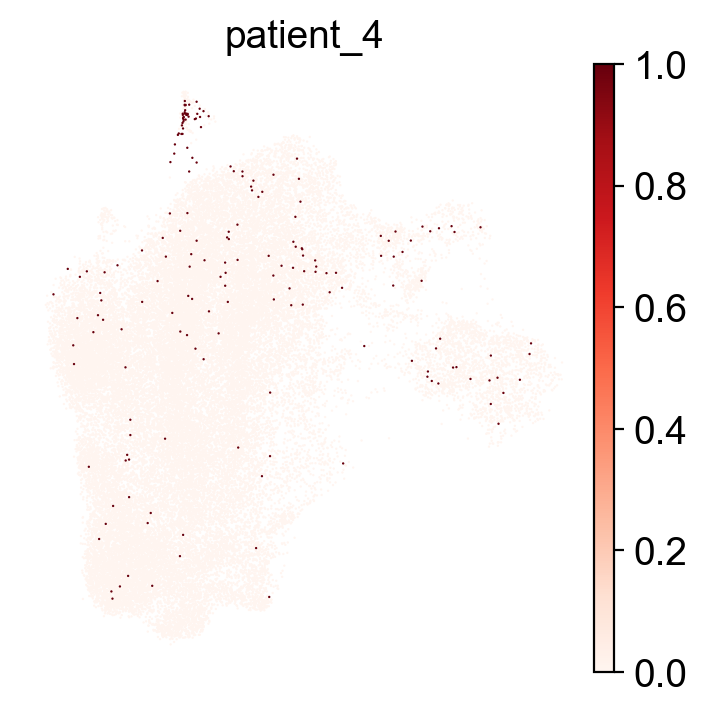

{'patient_1': None, 'patient_2': None, 'patient_3': None, 'patient_4': None}

In [9]:
# plot infected but not heavily infected cells
def f(p, adata):
    adata.obs['infected_thresh'] = [x > bg_lvl[p] for x in adata.obs.viral_counts]
    sc.pl.umap(adata[adata.obs.infected], color='infected_thresh', palette='Reds', title=p)
    
repeat(f)

It is possible that there is only an enrichment for viral counts in certain patients...?

In [51]:
adata.obs['treatment'] = adata.obs.treatment.astype('category')

In [67]:
# from scipy.stats import ttest_ind
# convenience function for standard plotting
def plot(df, x='viral_perc'):
    df = pd.DataFrame(df.stack()).T.melt()
    df.columns = ['treatment', 'patient', x]
    sns.boxplot(x, 'treatment', data=df, orient='horizontal', color='white')
    sns.stripplot(x, 'treatment', data=df, orient='horizontal', color='.3', size=4)

In [53]:
def plot_celltype(df, x='viral_perc', y='treatment', hue='cell_type'):
    """Takes in long form dataframes with celltype."""
    sns.boxplot(data=df, x=x, y=y, hue=hue, orient='horizontal', order=adata.obs.treatment.cat.categories)
    sns.stripplot(data=df, x=x, y=y, hue=hue, orient='horizontal', size=4, dodge=True, order=adata.obs.treatment.cat.categories)

### % infected per treatment

#### Based on % threshold

Fiege et al. (2021), for reference - they pick up many, many more viral transcripts:
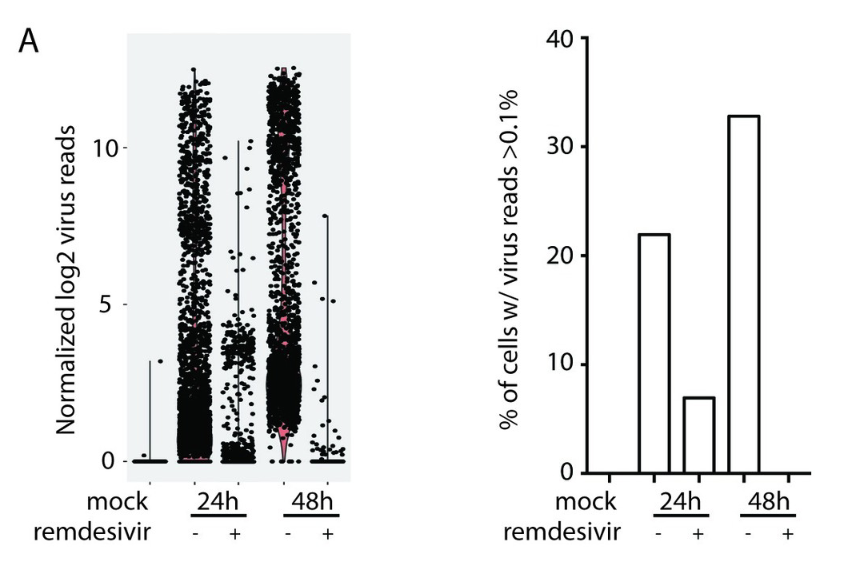

In [42]:
def f(p, adata):
    d = {}
    for trt in adata.obs.treatment.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.treatment == trt)]
        d[trt] = sum(subset.obs.percent_viral.values > .001)/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
# put mock at top
i = df.index.get_loc('mock')
df = df.iloc[[i] + list(range(i)) + list(range(i+1, len(df)))] 

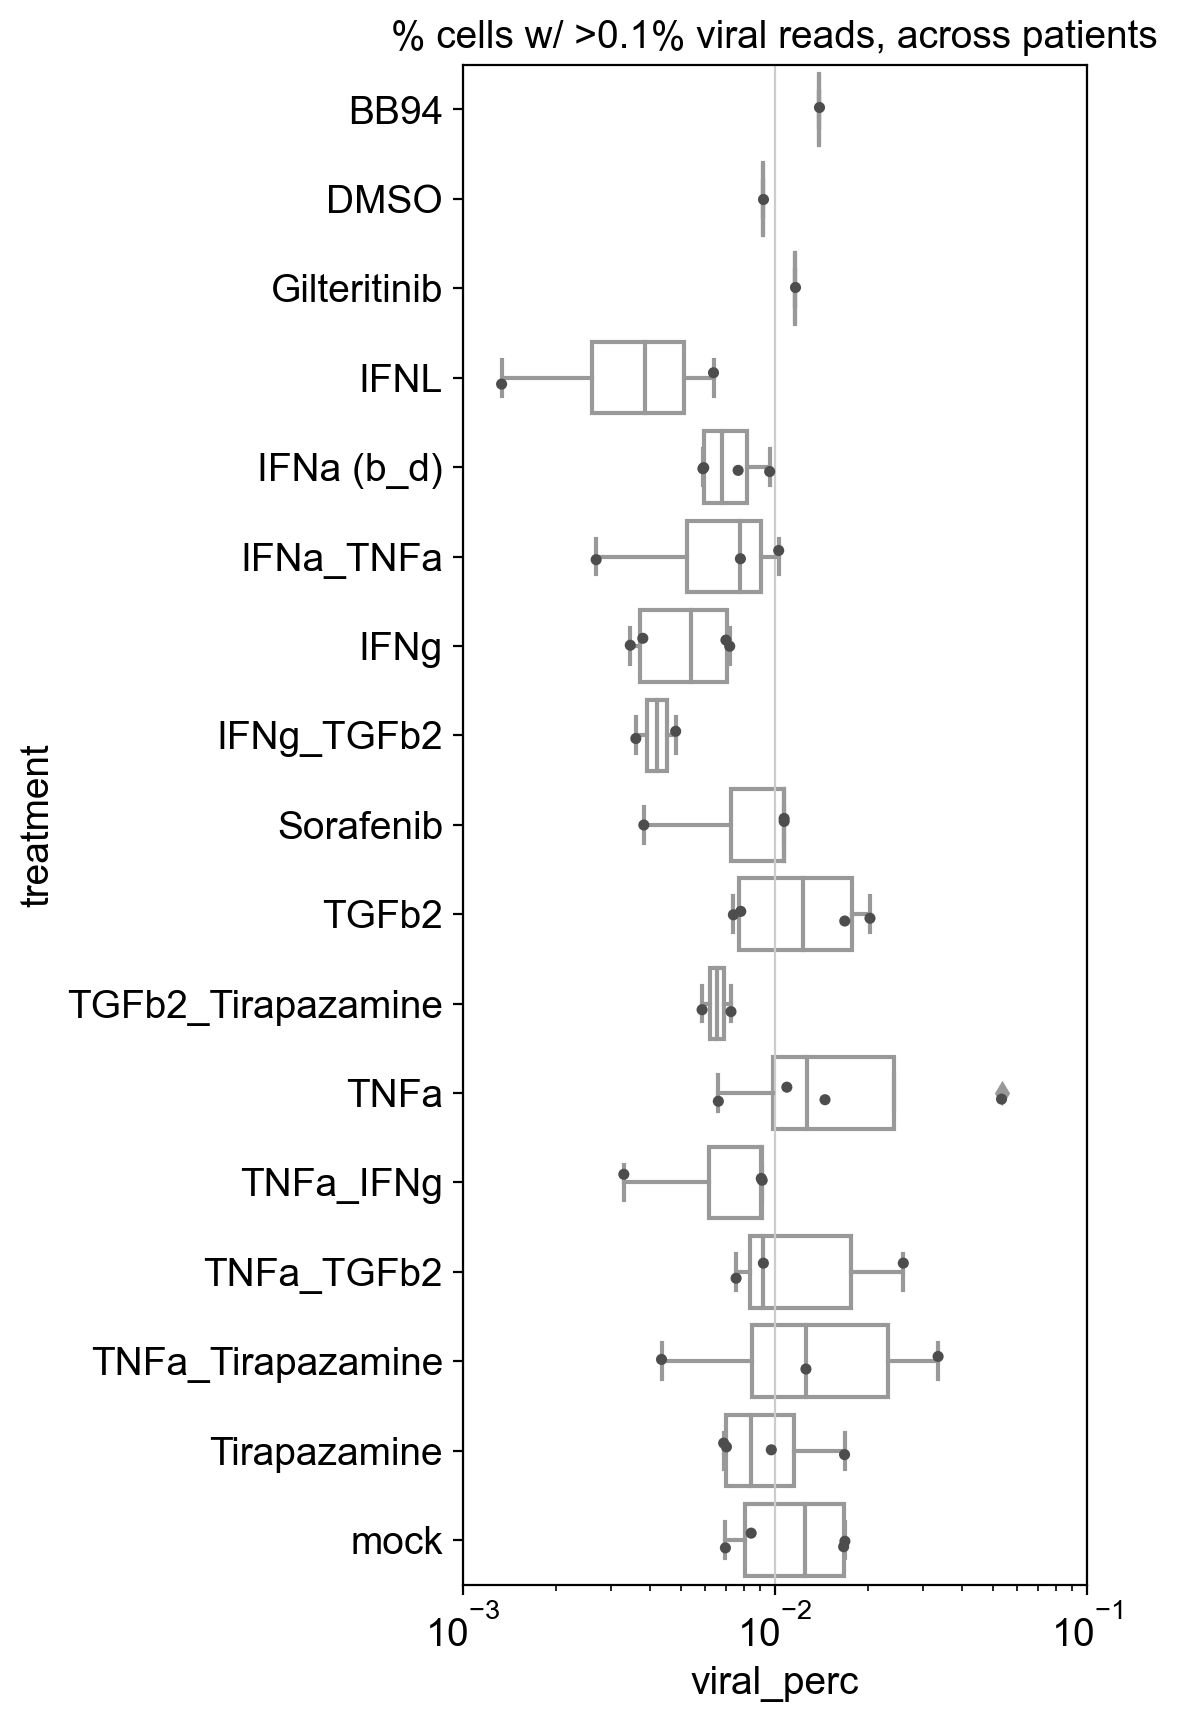

In [54]:
plt.figure(figsize=(4, 10))
plot(df)
plt.xscale('log')
plt.xlim(.001, .1)
plt.title('% cells w/ >0.1% viral reads, across patients');

Split by cell type:

In [55]:
from collections import defaultdict
def f(p, adata):
    adata = adata[adata.obs.infected == True]
    d = defaultdict(dict)
    for trt in adata.obs.treatment.unique():
        for ct in adata.obs.cell_type.unique():
            subset = adata[(adata.obs.treatment == trt) & (adata.obs.cell_type == ct)]
            
            if subset.shape[0] < 20:
                continue

            d[ct][trt] = sum(subset.obs.percent_viral.values > .001)/subset.shape[0] if subset.shape[0] else 0 
    return pd.DataFrame.from_dict(d)
perc_infected = repeat(f)

df = pd.DataFrame(pd.concat(perc_infected).stack()).T.melt()
df.columns = ['patient', 'treatment', 'cell_type', 'viral_perc']
df

patient     treatment cell_type  viral_perc
0    patient_1     TNFa_IFNg      club    0.002813
1    patient_1     TNFa_IFNg     basal    0.023747
2    patient_1     TNFa_IFNg       unk    0.000000
3    patient_1    IFNa (b_d)      club    0.002185
4    patient_1    IFNa (b_d)     basal    0.010638
..         ...           ...       ...         ...
159  patient_4  Tirapazamine  ciliated    0.006803
160  patient_4          IFNg      club    0.009302
161  patient_4          IFNg     basal    0.002497
162  patient_4          IFNg       unk    0.018519
163  patient_4          IFNg  ciliated    0.000000

[164 rows x 4 columns]

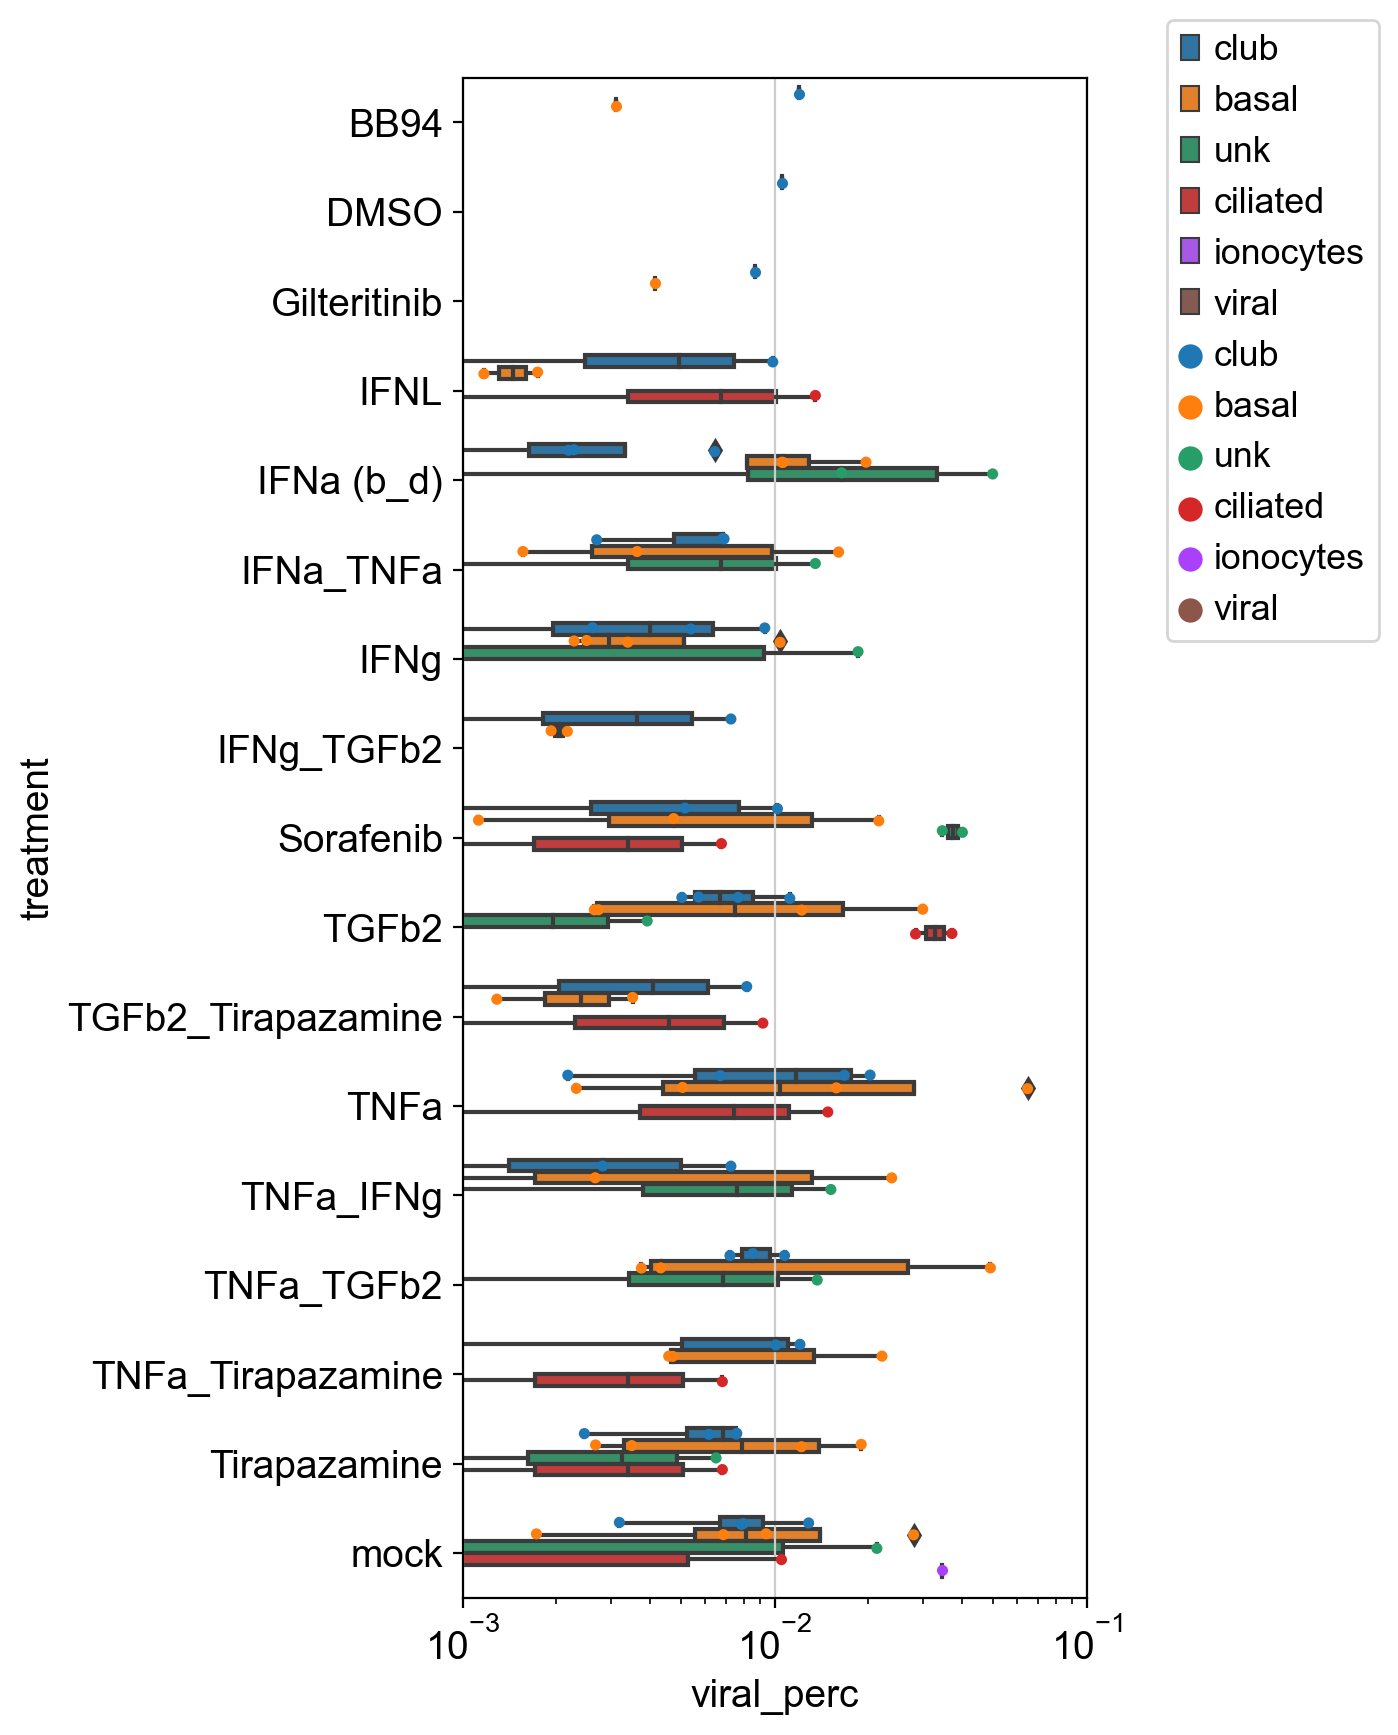

In [56]:
plt.figure(figsize=(4, 10))
plot_celltype(df)
plt.xscale('log')
plt.xlim(.001, .1)
plt.legend(bbox_to_anchor=(1.1, 1.05));

#### Based on absolute threshold

In [58]:
def f(p, adata):
    d = {}
    for trt in adata.obs.treatment.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.treatment == trt)]
        d[trt] = sum(subset.obs.viral_counts.values > 10)/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
# put mock at top
i = df.index.get_loc('mock')
df = df.iloc[[i] + list(range(i)) + list(range(i+1, len(df)))] 
# # add column for p-vals
# pvals = [1]
# for p in df.index.values[1:]:
#     pvals.append(-np.log10(ttest_ind(df.T[p][~np.isnan(df.T[p])].values, df.T['mock'].values)[1]))
# df['-log10(pval)'] = pvals
# df

TODO: add p-values based on single-cell viral count values

In [59]:
plt.figure(figsize=(4, 7))
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients');
# plt.grid(b=False)

#### check for differences between viral transcript types


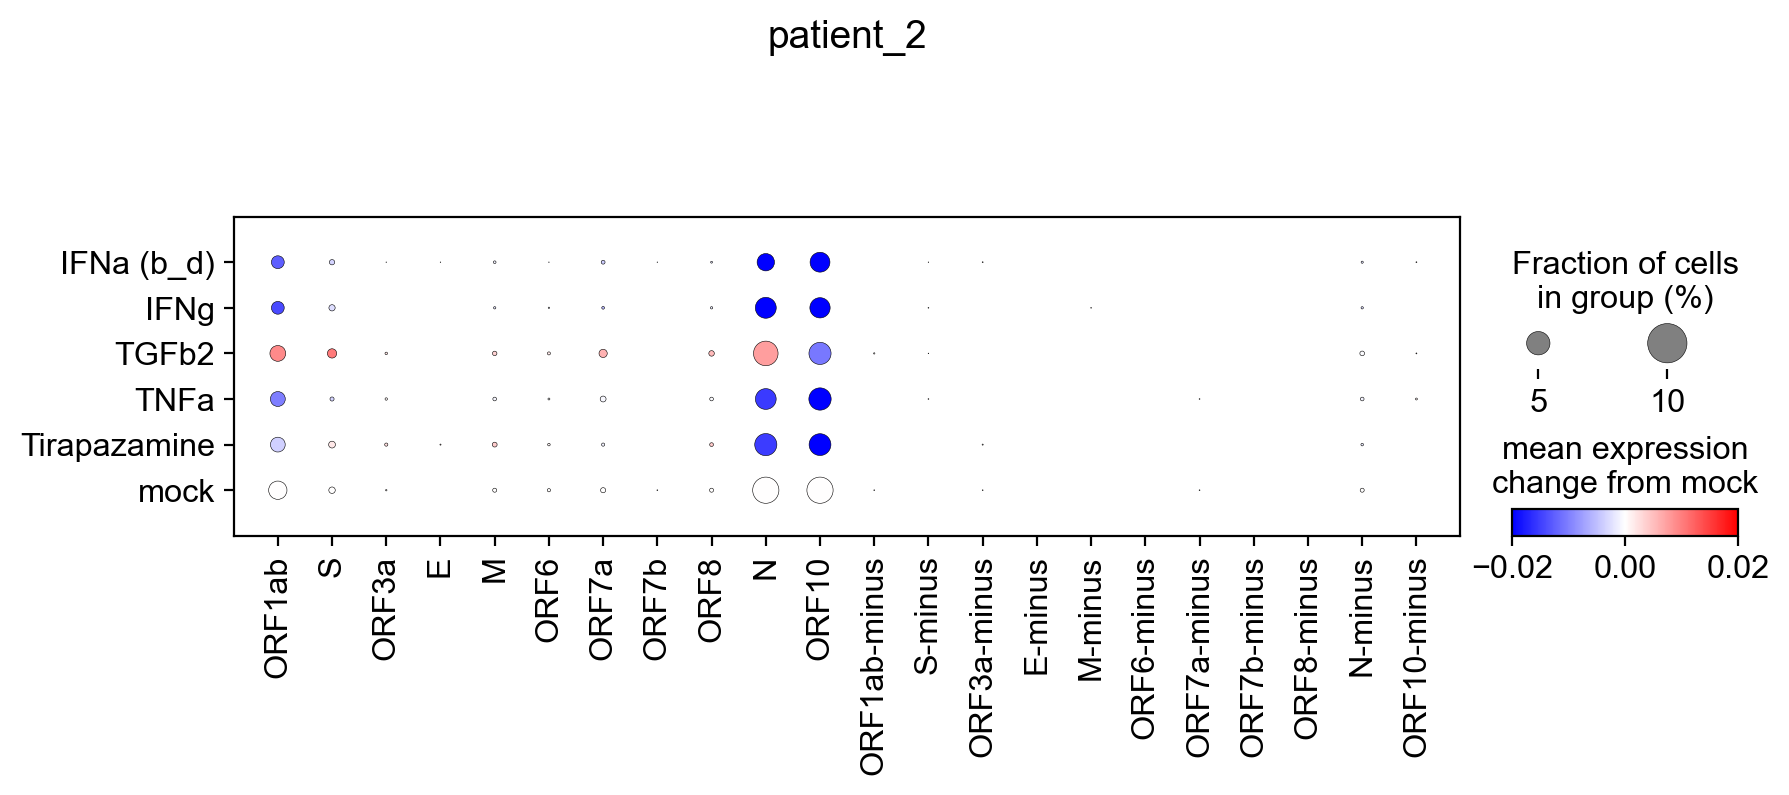

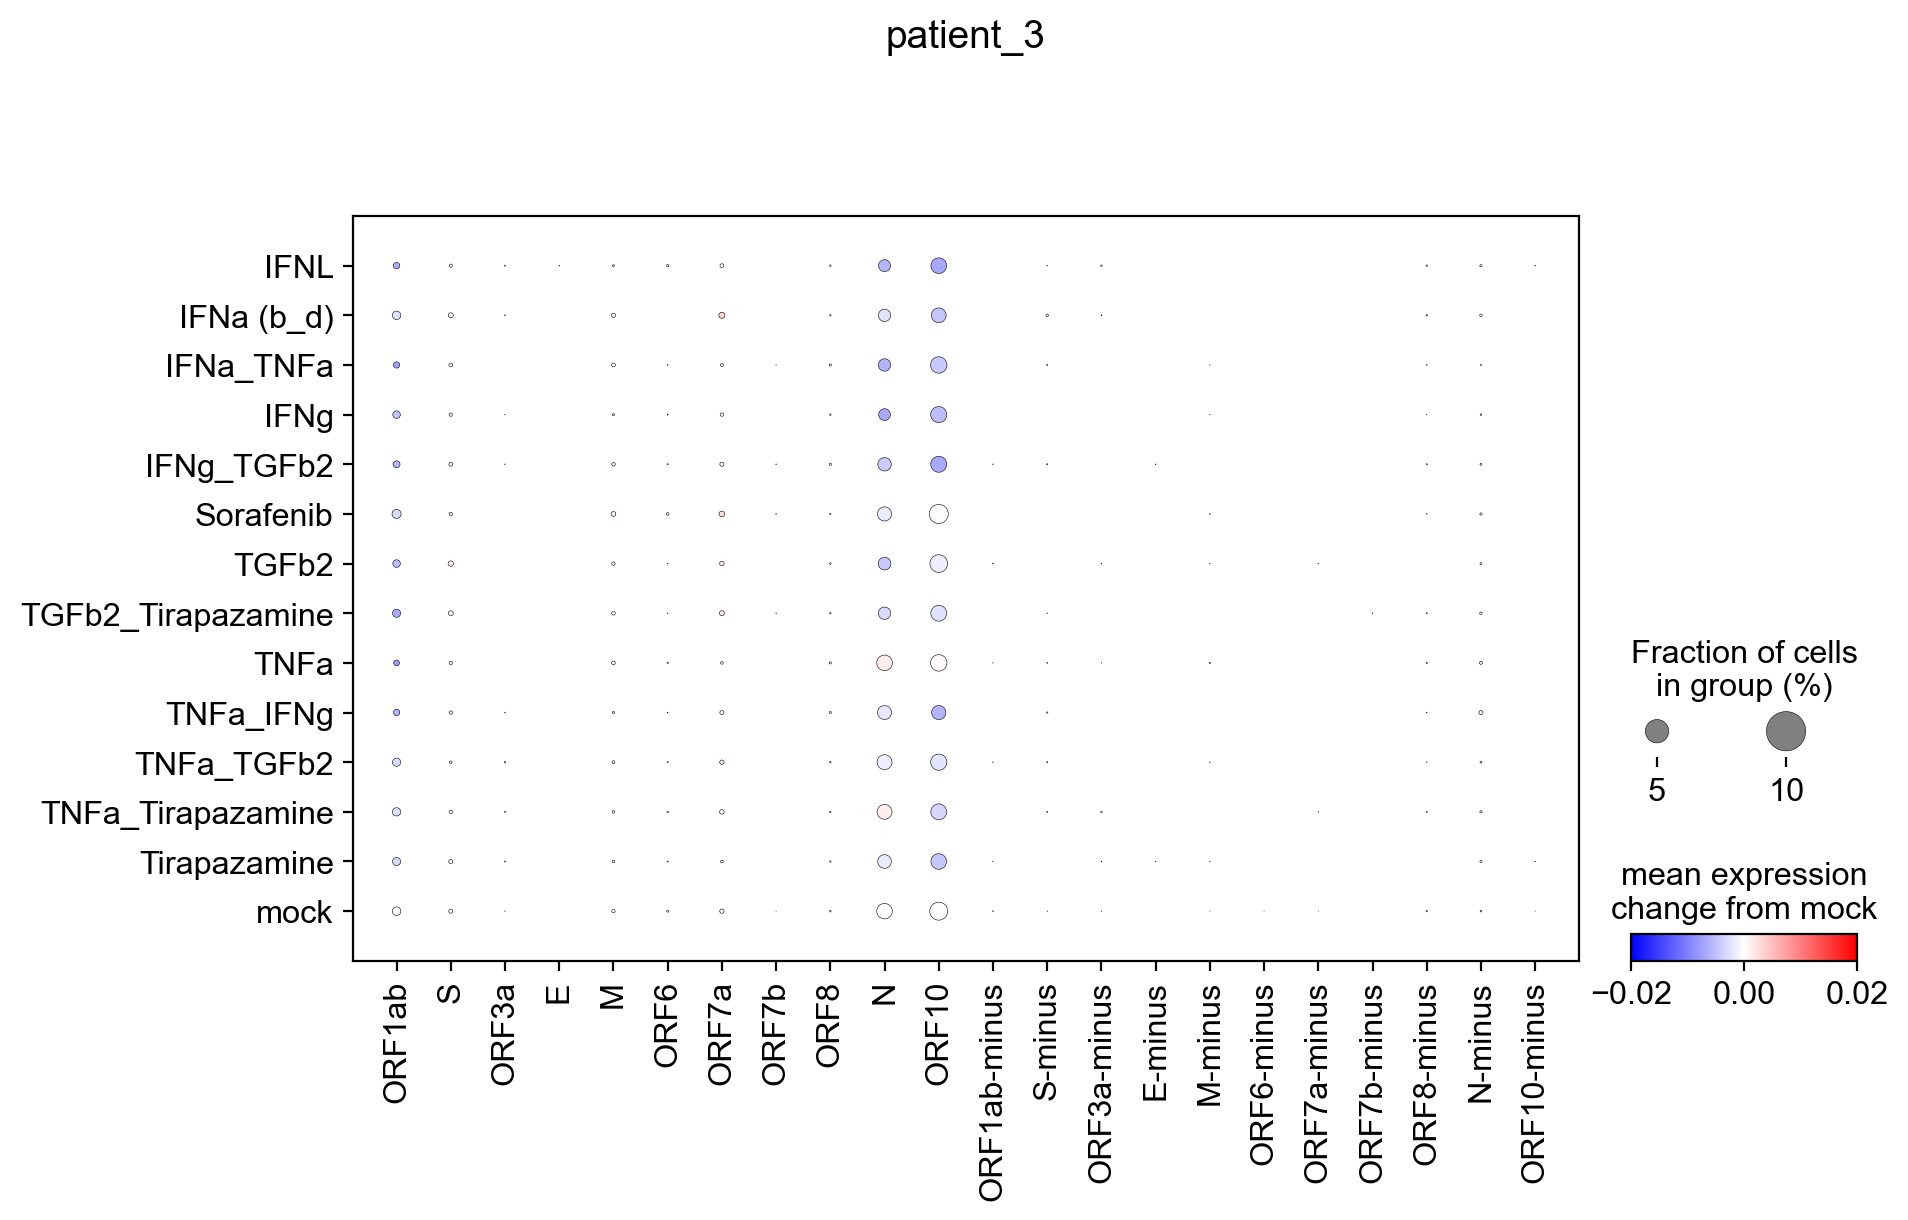

{'patient_1': None, 'patient_2': None, 'patient_3': None, 'patient_4': None}

In [69]:
def f(p, adata):
    subset = adata[adata.obs.infected == True]
    viral_genes = adata.var.index[adatas['patient_3'].var.viral.values]
    fig = sc.pl.dotplot(
        subset, var_names=viral_genes, groupby='treatment',
        return_fig=True)
    sc.pl.dotplot(
        subset, var_names=viral_genes, groupby='treatment',
        dot_color_df = fig.dot_color_df - fig.dot_color_df.loc['mock'],
        cmap='bwr', colorbar_title='mean expression\nchange from mock', vmax=.02, vmin=-.02, title=p)
repeat(f)

Summarized:

In [29]:
sc.pl.violin(adata[adata.obs.infected == True].copy(), keys='log2(viral_counts)', groupby='treatment', rotation=90)

... storing 'identifier' as categorical
... storing 'patient' as categorical
... storing 'name' as categorical
... storing 'barcode_round' as categorical
... storing 'sample' as categorical
... storing 'treatment' as categorical
... storing 'treatment_virus' as categorical
... storing 'leiden' as categorical
... storing 'final_bcs' as categorical
... storing 'batch' as categorical
... storing 'celltype_coarse' as categorical


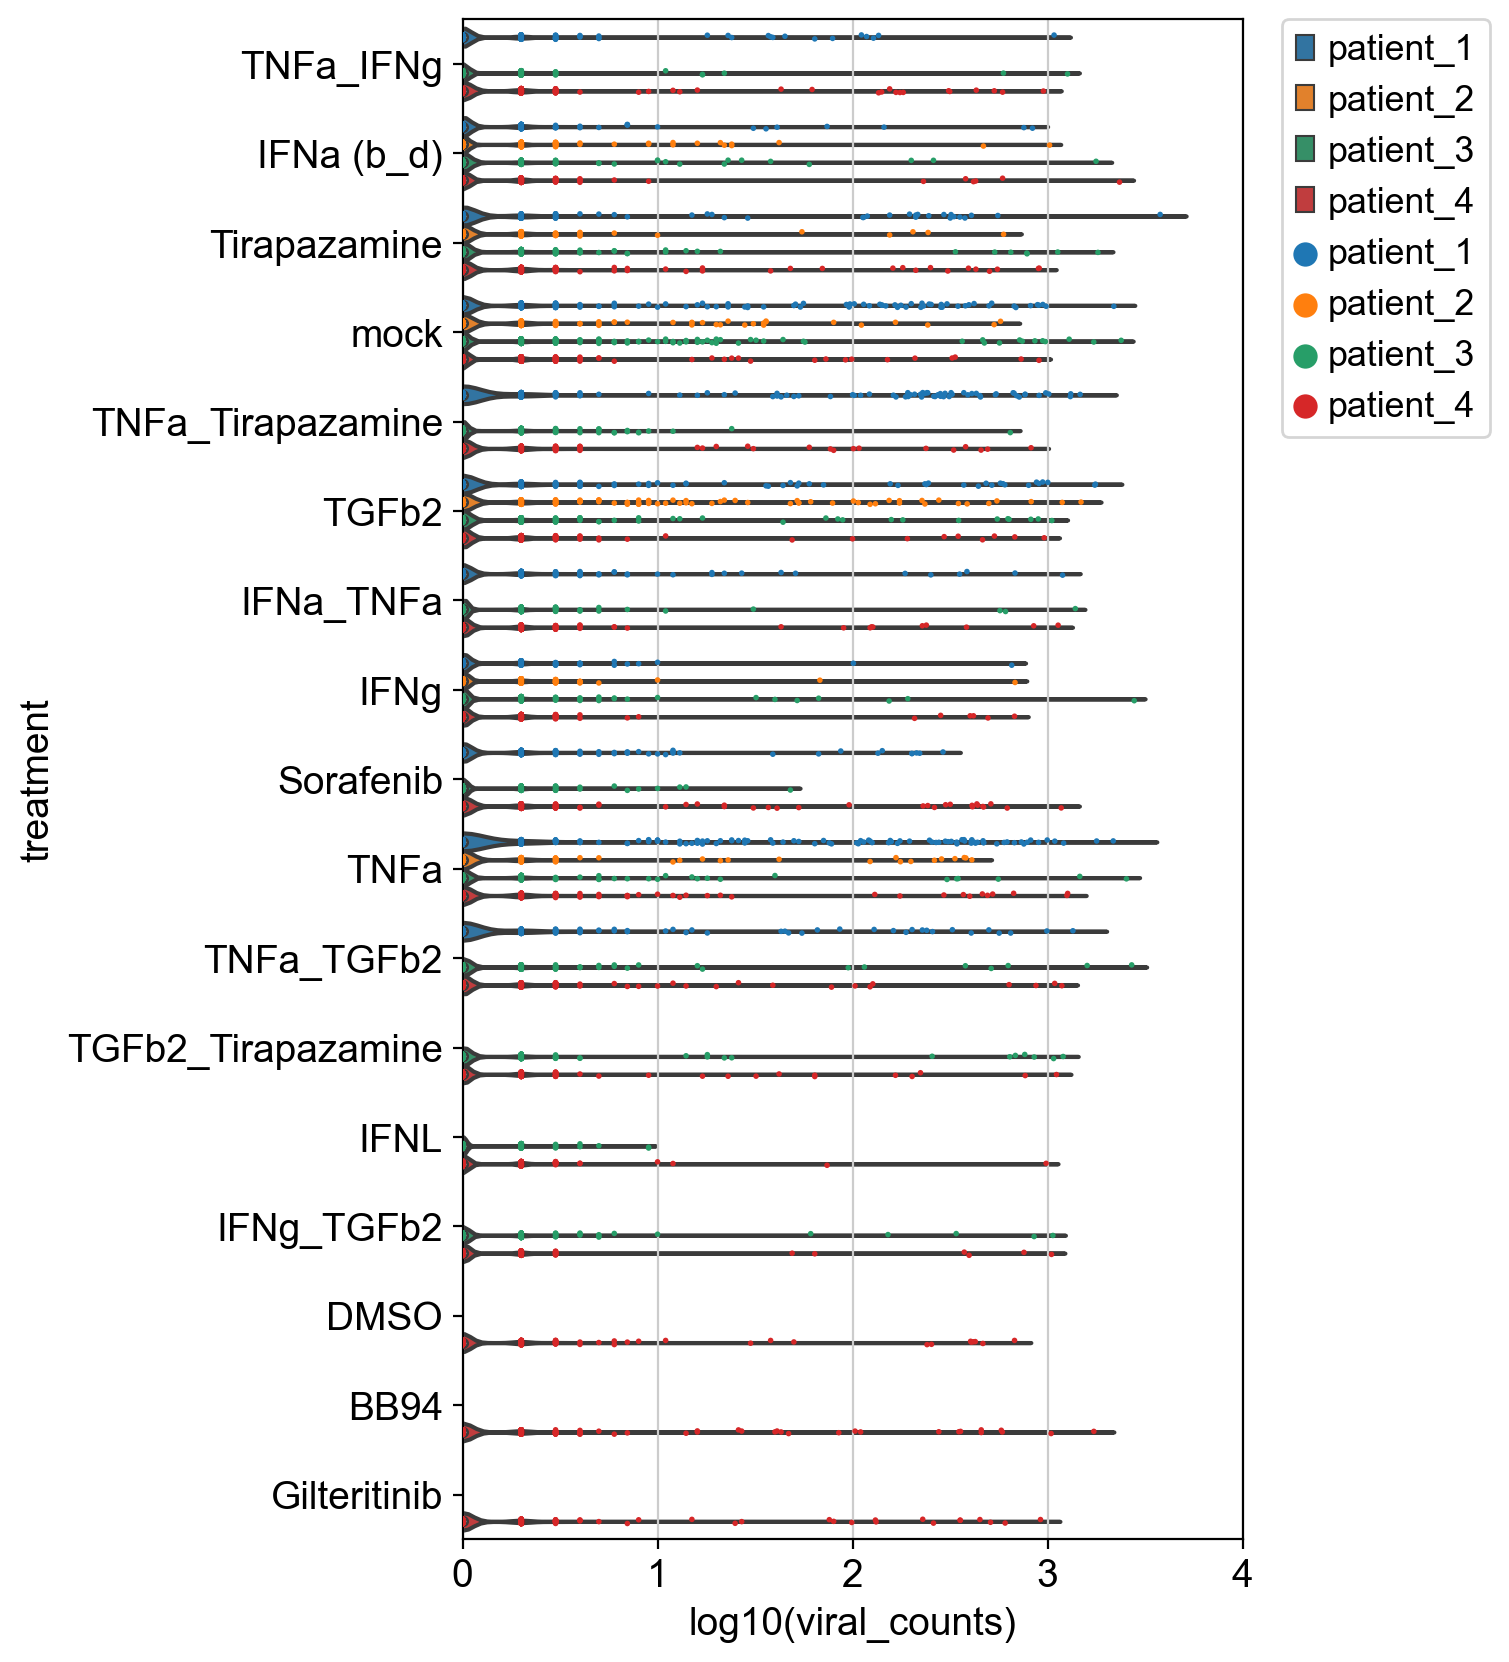

In [57]:
plt.figure(figsize=(5, 10))  # should replace with sc.pl.violin :/
sns.violinplot(
    data=adata[adata.obs.infected == True].obs, x='log10(viral_counts)', y='treatment', hue='patient', scale='width')
sns.stripplot(
    data=adata[adata.obs.infected == True].obs, x='log10(viral_counts)', y='treatment', hue='patient', jitter=1, size=2, dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
plt.xlim(0, 4);

### % infected per cell type

First, remove cells that are extremely infected and therefore don't exhibit any specific cell type:

In [21]:
adatas = repeat(lambda p, adata: adata[adata.obs.viral_counts < bg_lvl_high[p]])

In [57]:
# count per cell type
pd.crosstab(adata[adata.obs.treatment == 'mock'].obs.infected, adata[adata.obs.treatment == 'mock'].obs.cell_type)

cell_type  basal  brush  ciliated  club  goblet  ionocytes  unk  viral
infected                                                              
False       6909     27       208  6822       4         37  871     25
True        9071     30       298  6588      13         59  225     65

Percent of cells per cell type in the virus treated sample (mock only) containing above-background levels of viral transcript, per replicate (patient).

In [58]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.cell_type == ct) & (adata.obs.treatment == 'mock')]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

patient_1  patient_2  patient_3  patient_4
club        0.008515   0.016641   0.001060   0.002163
viral       1.000000   0.833333   1.000000   1.000000
basal       0.011737   0.009302   0.008227   0.002415
ionocytes   0.034483   0.000000   0.000000   0.000000
ciliated    0.000000   0.000000   0.000000   0.010526
unk         0.000000   0.000000   0.000000   0.010638
brush       0.000000   0.000000   0.000000   0.000000
goblet      0.000000   0.000000   0.000000   0.000000

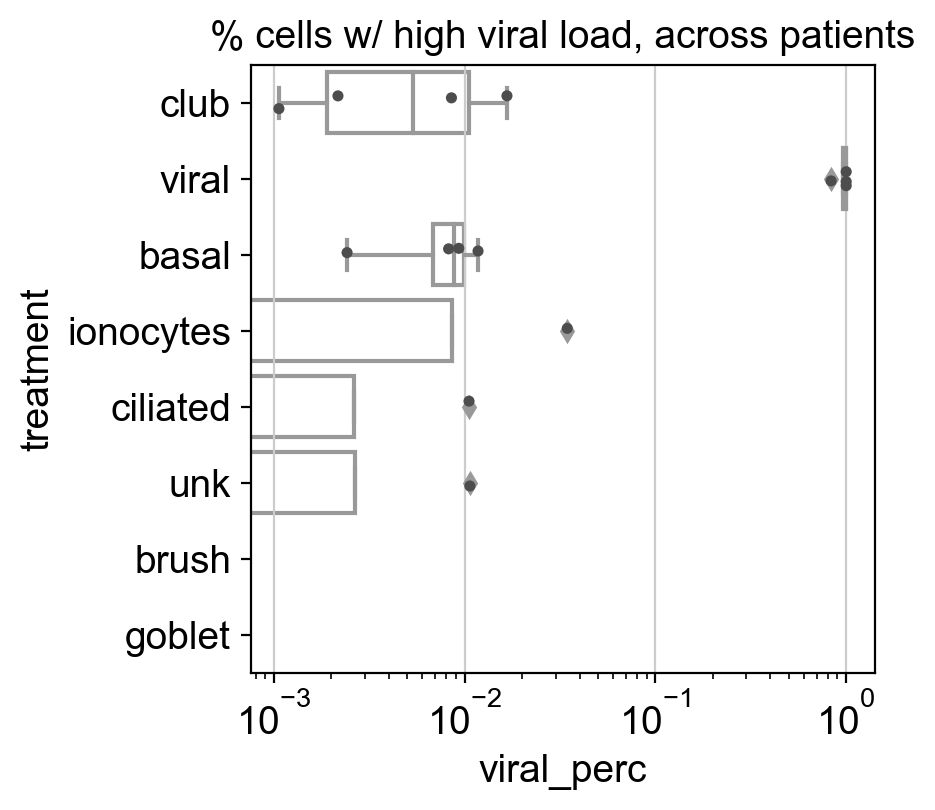

In [68]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients');
# plt.grid(b=False)

Not sure why we don't see that ciliated cells are more infected as in the other datasets. Number of infected cells (where infection = viral count > 10)


And as control:

In [25]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == False) & (adata.obs.cell_type == ct) & (adata.obs.treatment == 'mock')]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

patient_1  patient_2  patient_3  patient_4
club        0.006364   0.007692   0.018034   0.001637
basal       0.004985   0.007855   0.001200   0.001223
ionocytes   0.000000   0.000000   0.000000   0.000000
ciliated    0.000000   0.000000   0.000000   0.007143
goblet      1.000000   0.000000        NaN   0.000000

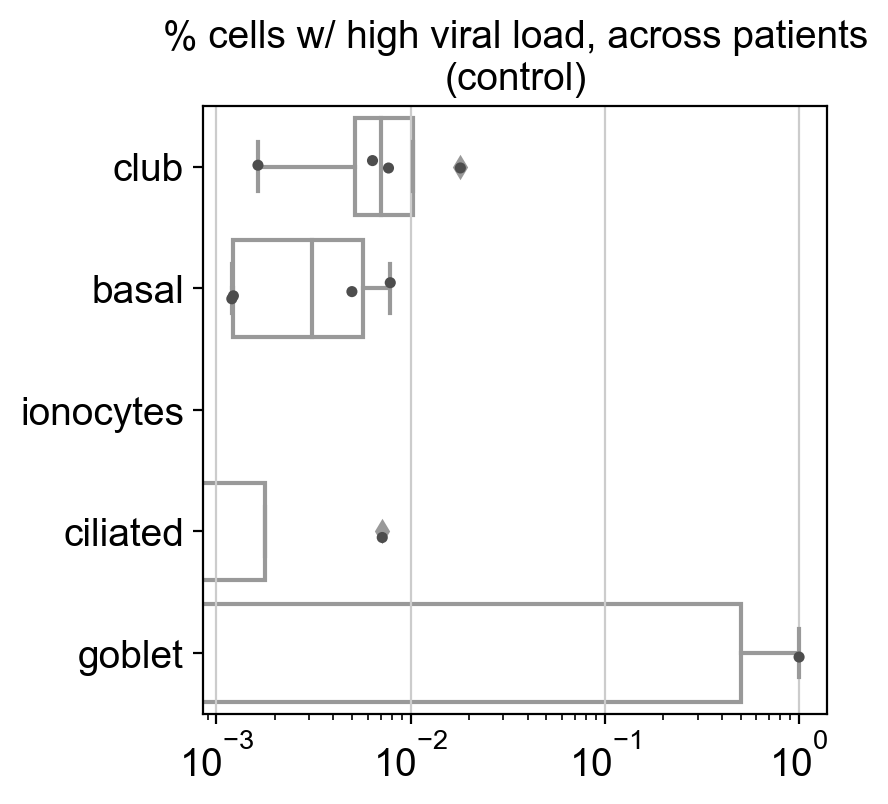

In [26]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients\n(control)');

With more samples (including all shared compounds so it's still comparable) - mostly as a sanity check since the counts for some cell types were extremely low. We can't make statements from this plot.

In [27]:
df = pd.crosstab(adata.obs.patient, adata.obs.treatment)
shared_cmpds = df.columns[df.all().values]

In [28]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.cell_type == ct) & (adata.obs.treatment.isin(shared_cmpds))]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

patient_1  patient_2  patient_3  patient_4
club        0.013141   0.014043   0.017771   0.003971
basal       0.014016   0.008220   0.001304   0.001858
ionocytes   0.012500   0.000000   0.000000   0.000000
ciliated    0.000000   0.013699   0.000000   0.011111
goblet      1.000000   0.000000        NaN   1.000000

In [29]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients\n(including shared treatments)');